# 데이터 전처리

## 데이터 불러오기

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 필요한 library import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


# 데이터 불러오기
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FC/data/DataCoSupplyChainDataset.csv", encoding_errors='ignore')
df_des = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FC/data/DescriptionDataCoSupplyChain.csv", encoding_errors='ignore')

In [ ]:
print(df.shape) # 행열 개수 확인
print(df.info()) # 기본 정보 확인

## 데이터 정제

In [ ]:
# 각 변수별 결측치 개수 확인
df.isnull().sum()

4개의 변수에서 결측치 발견
- Customer Zipcode 3개
- Customer Lname 8개
- Order Zipcode 180519개
- Product Description 155679개


In [ ]:
# Date 관련 변수를 datetime 자료형으로 만들기
df["order date (DateOrders)"] = pd.to_datetime(df["order date (DateOrders)"])
df["shipping date (DateOrders)"]=pd.to_datetime(df["shipping date (DateOrders)"])
df = df.sort_values(by="order date (DateOrders)")

In [ ]:
# 결측치 있는 변수 처리
# Customer Full Name 변수 생성
df['Customer Full Name'] = df['Customer Fname'].astype(str)+df['Customer Lname'].astype(str)

# Customer Zipcode의 결측치를 최빈값으로 채우기
column_index = df.columns.get_loc("Customer Zipcode")
# Get the index of the column "Customer Zipcode"
df['Customer Zipcode'] = df['Customer Zipcode'].fillna(df.mode().iloc[column_index])

# Order Zipcode는 필요 없어서 이후 제거
# Product Description 변수는 전체 결측치이므로 버린다

## 변수 처리

In [ ]:
# 필요 없는 변수 제거
data=df.drop(['Order Zipcode','Product Description', 'Customer Email','Customer Password','Product Status','Customer Street','Customer Fname','Customer Lname',
           'Latitude','Longitude','Product Image',],axis=1)
data.shape

In [ ]:
# 변수 이름 변경
data.columns = [col.lower().replace(' ', '_') for col in data.columns]
data.rename(columns=lambda x: x.replace("(", "").replace(")", ""), inplace=True)

In [ ]:
# 완성된 정제 데이터 내보내기
data.to_csv('/content/drive/MyDrive/Colab Notebooks/FC/project_data_clean.csv')

# 데이터 분석

## 상관분석

In [ ]:
# 필요한 library import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# 데이터 불러오기
data = pd.read_csv("/content/drive/MyDrive/패캠_파이썬프로젝트_5조/project_data_clean.csv", encoding_errors='ignore')

<ipython-input-124-2939b349f5ae>:5: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

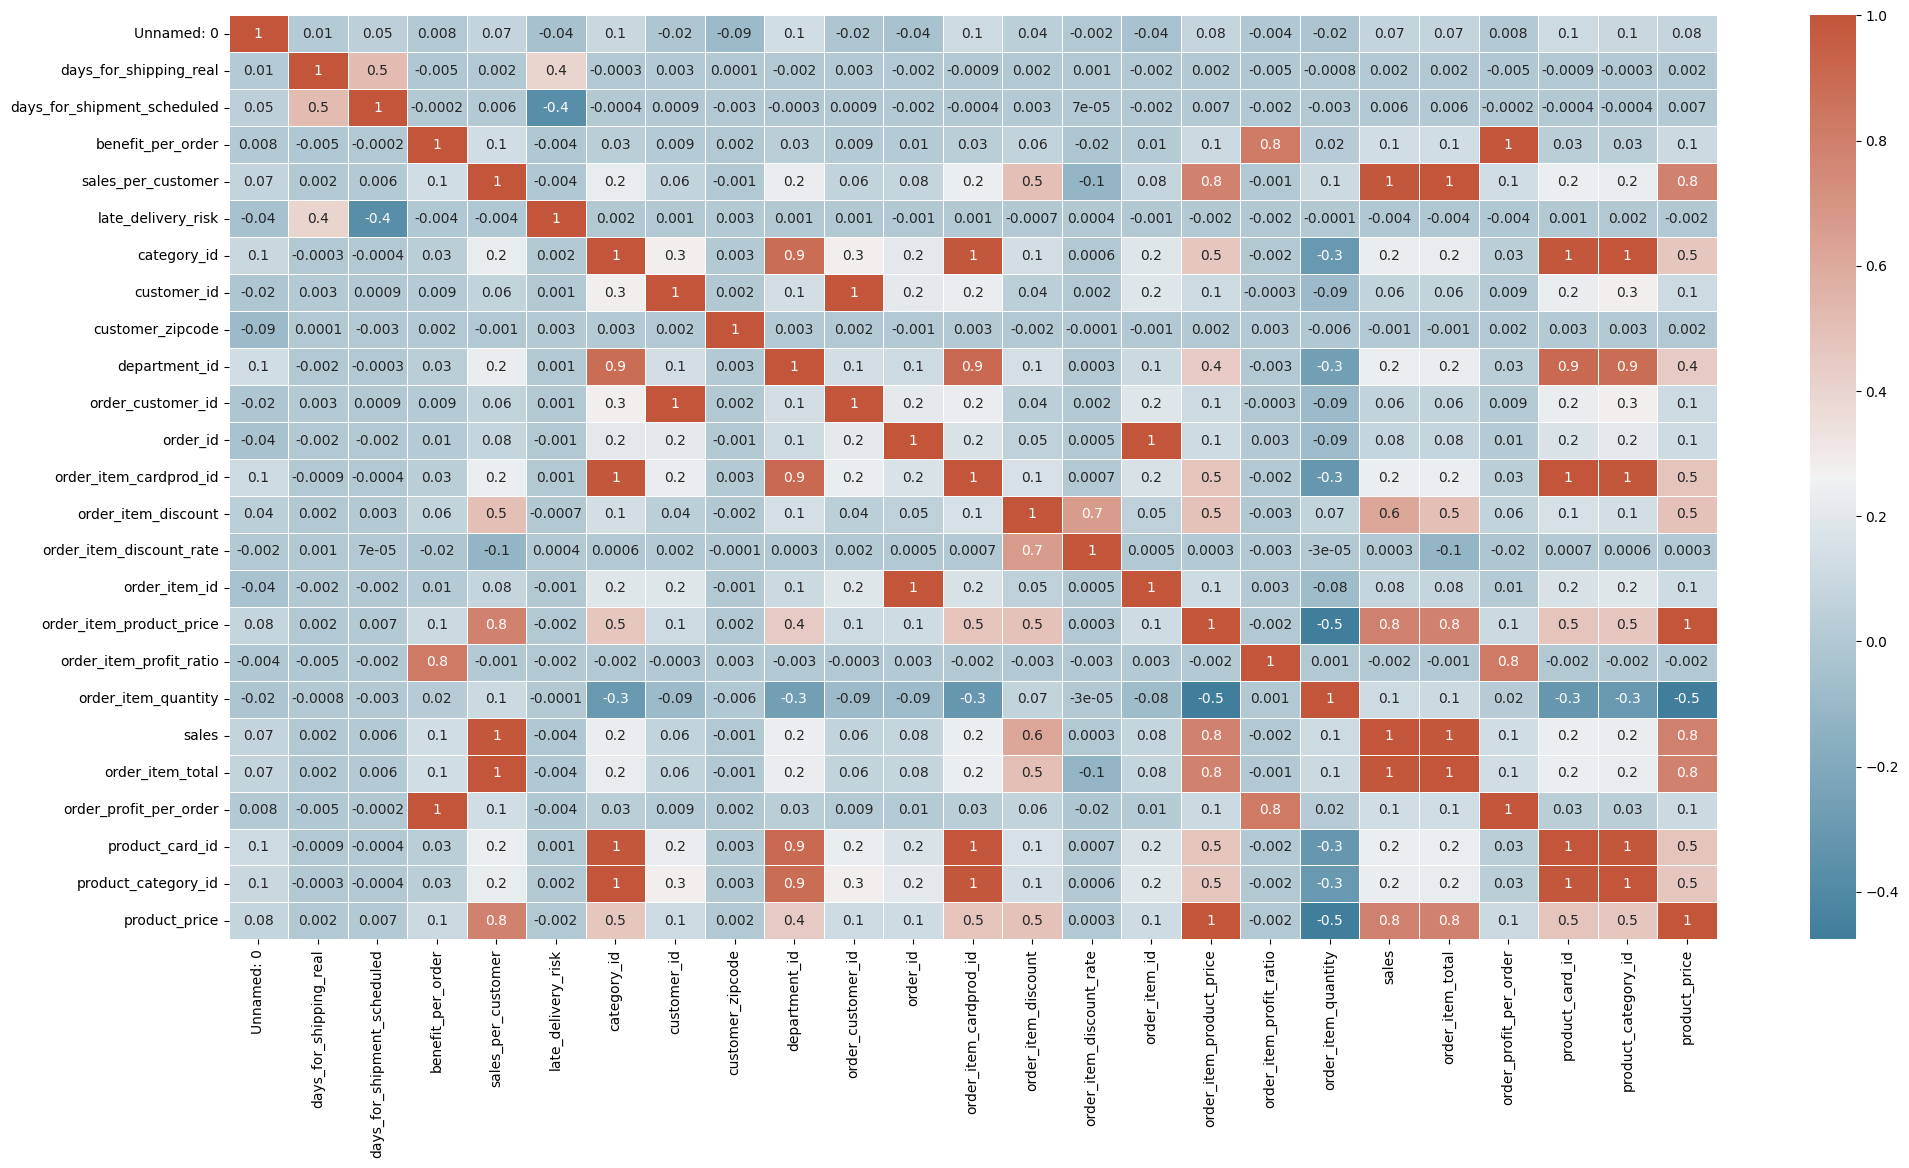

In [ ]:
# 상관분석 결과
fig, ax = plt.subplots(figsize=(24,12)) # figsize

# Heatmap for correlation matrix 그리기
sns.heatmap(data.corr(),annot=True,linewidths=.5,fmt='.1g',
            cmap= sns.diverging_palette(230, 20, as_cmap=True))


- sales와 유의한 상관관계를 가지는 것은 Order Item Discount(0.6), Order Item Product Price(0.8)
- order_item_discount와 sales per customer는 양의 상관관계(0.5)
- order_item_product_price와 상관이 있는 것: sales_per_customer(0.8), category_id(0.5), department_id(0.4), order_item_cardprod_id(0.5), order_item_discount(0.5)

## (1) 영업 이익 관련 데이터 분석 (Order Profitability)


sales와 할인율

In [ ]:
import scipy.stats as stats

# 데이터프레임에서 'sales'와 'discount' 열 선택
sales = data['sales']
discount = data['order_item_discount']

# 피어슨 상관계수 및 p-value 계산
correlation, p_value = stats.pearsonr(sales, discount)

# 결과 출력
print(f"Pearson Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

# 가설 검정
alpha = 0.05
if p_value < alpha:
    print("귀무가설을 기각하고 대립가설을 채택합니다. sales와 discount 간에는 통계적으로 유의미한 선형 관계가 있습니다.")
else:
    print("귀무가설을 기각하지 못하며, sales와 discount 간에는 통계적으로 유의미한 선형 관계가 없습니다.")

Pearson Correlation Coefficient: 0.6174376349284931
P-value: 0.0
귀무가설을 기각하고 대립가설을 채택합니다. sales와 discount 간에는 통계적으로 유의미한 선형 관계가 있습니다.


sales와 할인율 간에는 유의한 관계가 있다
우연히 발생할 확률이 매우 낮다

### 1) 할인율에 따른 order profitability


- 새로운 변수 **profit_or_lose** 정의
    - order_profit_per_order column이 0보다 크면 "profit"
    - order_profit_per_order column이 0보다 크면 "lose"

In [ ]:
# 새로운 변수 정의
data["profit_or_lose"] = np.where(data.order_profit_per_order>=0,"profit","lose")

- 가설 설정
    - H0 = 할인을 했다고 해서, 일부 주문에서 이익이 발생한다고 보기 어렵다. (이익 주문의 할인율 평균 - 손실 주문의 할인율 평균 < 0)
    - H1 = 할인을 하면, 일부 주문에서 이익이 발생한다. (이익 주문의 할인율 평균 - 손실 주문의 할인율 평균 >= 0)

(추가설명 : 할인율이 높아서 매출이 잘나오고, 그에 따라 이익이 높은 것이라면 이익 주문의 할인율 평균이 더 높아야한다고 생각하여서 조건을 위와 같이 설정함)

In [ ]:
# 손실을 발생시키는 주문들의 할인율 평균
mean_lose_orders = data.query("profit_or_lose == 'lose'").order_item_discount_rate.mean()
print ("mean of the discount of the making lose orders : ", mean_lose_orders)

mean of the discount of the making lose orders :  0.1022223542650071


In [ ]:
# 이익을 발생시키는 주문들의 할인율 평균
mean_profit_orders = data.query("profit_or_lose == 'profit'").order_item_discount_rate.mean()
print (" the mean of the discount of profit orders : ",mean_profit_orders)

 the mean of the discount of profit orders :  0.10154060090484204


In [ ]:
# 이익 주문의 할인율 평균 - 손실 주문의 할인율 평균
obs_sample = mean_profit_orders - mean_lose_orders
print("the differance between the means : ",obs_sample)

the differance between the means :  -0.0006817533601650577


'means_diffs' 리스트는 반복문을 통해 생성되며, 각 반복에서 무작위로 선택된 데이터 샘플에 대해 이익 주문과 손실 주문의 할인율 평균 차이를 계산한 값을 저장한다.

In [ ]:
# 데이터를 추출하여, lose의 할인율 평균에서 profit의 할인율 평균을 뺀 값을 계산
means_diffs = []

for _ in range(10000):
    b_sample = data.sample(10000,replace= True)
    mean_lose = b_sample.query("profit_or_lose == 'lose'").order_item_discount_rate.mean()
    mean_profit = b_sample.query("profit_or_lose == 'profit'").order_item_discount_rate.mean()

    means_diffs.append(mean_profit - mean_lose)

- 'null_val'은 표준 정규 분포를 따르는 무작위 값으로 구성된 배열을 생성한다.
- 이 배열의 길이는 'means_diffs'의 길이와 동일하며, 각 값은 평균이 0이고 표준 편차가 'means_diffs_std'인 정규 분포에서 추출한 값입니다.

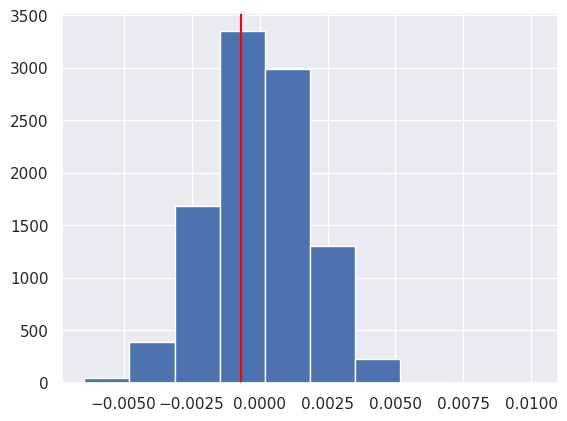

In [ ]:
means_diffs_std = np.std(means_diffs) #표준편차 계산

# 평균이 0이고, 표준편차가 mean_diffs_std인 정규분포를 means_diffs 길이만큼 생성
# 이는 귀무가설에서 기대되는 평균 차이가 없는 경우의 분포를 나타냄

null_val = np.random.normal(0, means_diffs_std, len(means_diffs))
plt.hist(null_val,edgecolor='black') #히스토그램 시각화
plt.grid(False)
plt.axvline(obs_sample, c = "Red");

In [ ]:
# 귀무가설 분포에서 실제 관측된 표본 평균 차이보다 큰 값들을 선택하고, 그 값의 비율을 계산한다
# 이는 귀무가설 분포에서 실제 관측된 표본 평균 차이보다 큰 값이 나올 확률을 계산한다.

P_value = ( null_val >= obs_sample).mean()
print("P_value:" , P_value)

P_value: 0.3545


- (null_val >= obs_sample)는 각각의 null_val 값이 obs_sample 이상인지를 나타내는 배열을 생성한다.
- mean()을 사용하여 이 배열의 평균을 계산한다.
- 이는 obs_sample보다 크거나 같은 값을 가진 표본이 전체 표본 중 어느 정도의 비율을 차지하는지를 나타내므로, 이 값이 p-value가 됩니다.
- 따라서, null_val이 obs_sample보다 더 극단적인 값이 나타날 확률이 높다면, 이는 귀무가설을 기각할 수 없는 것이다.
- 결론 : p-value가 0.05보다 크므로, 귀무가설 기각 불가능. 즉, 할인을 했다고 해서, 일부 주문에서 이익이 발생한다고 보기 어렵다.

- 결론 : p-value가 0.05보다 크므로 귀무가설 기각 불가능.  즉, 할인을 했다고 해서, 일부 주문에서 이익이 발생한다고 보기 어렵다.
- 따라서, 이익을 올리기 위해 할인을 진행하는 것은 바람직하지 않다

### 2) 제품 카테고리와 Order Profitability와의 관계



#### 판매량 분석

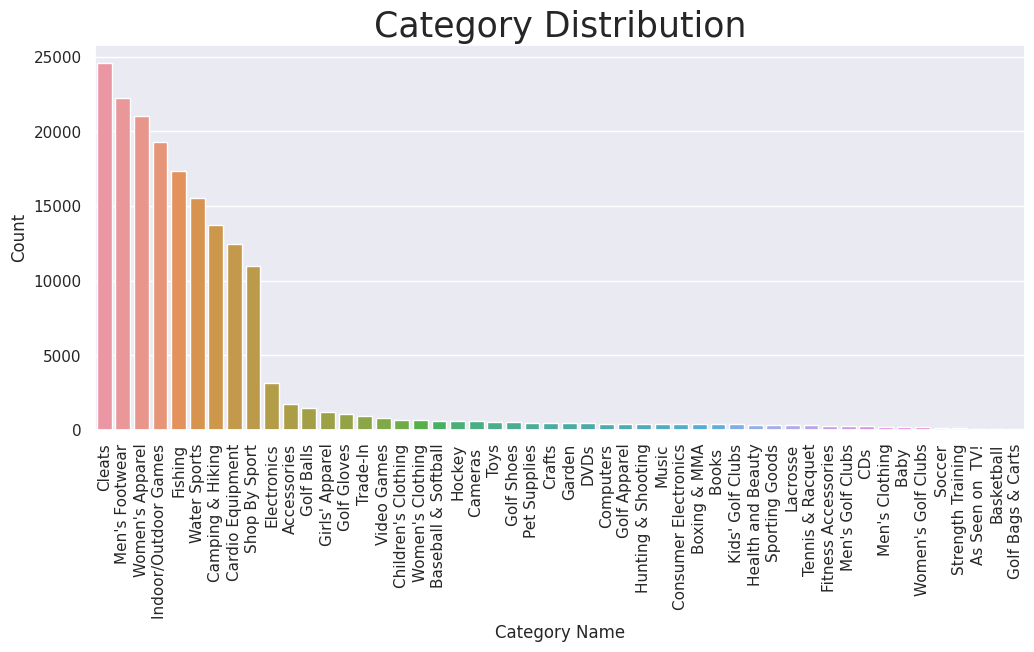

In [ ]:
# 가장 많이 팔리는 카테고리
category_counts = data['category_name'].value_counts().sort_values(ascending=False)

# 막대그래프 그리기
plt.figure(figsize=(12,5))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xticks(rotation='vertical')
plt.title('Category Distribution', fontsize=25)
plt.ylabel('Count')
plt.xlabel('Category Name')
plt.grid(False)
plt.show()

Cleats가 가장 많이 팔린 카테고리였고, Golf Bags &Carts가 가장 적게 팔린 카테고리였다. 그렇다면 가장 수익을 많이 낸 항목은 무엇인가?

Perfect Fitness Perfect Rip Deck 가 가장 많이 팔린 제품이다. 뿐만 아니라 상위 9개 상품은 다른 제품에 비교했을 때 압도적으로 많이 판매된 것을 알 수 있다.



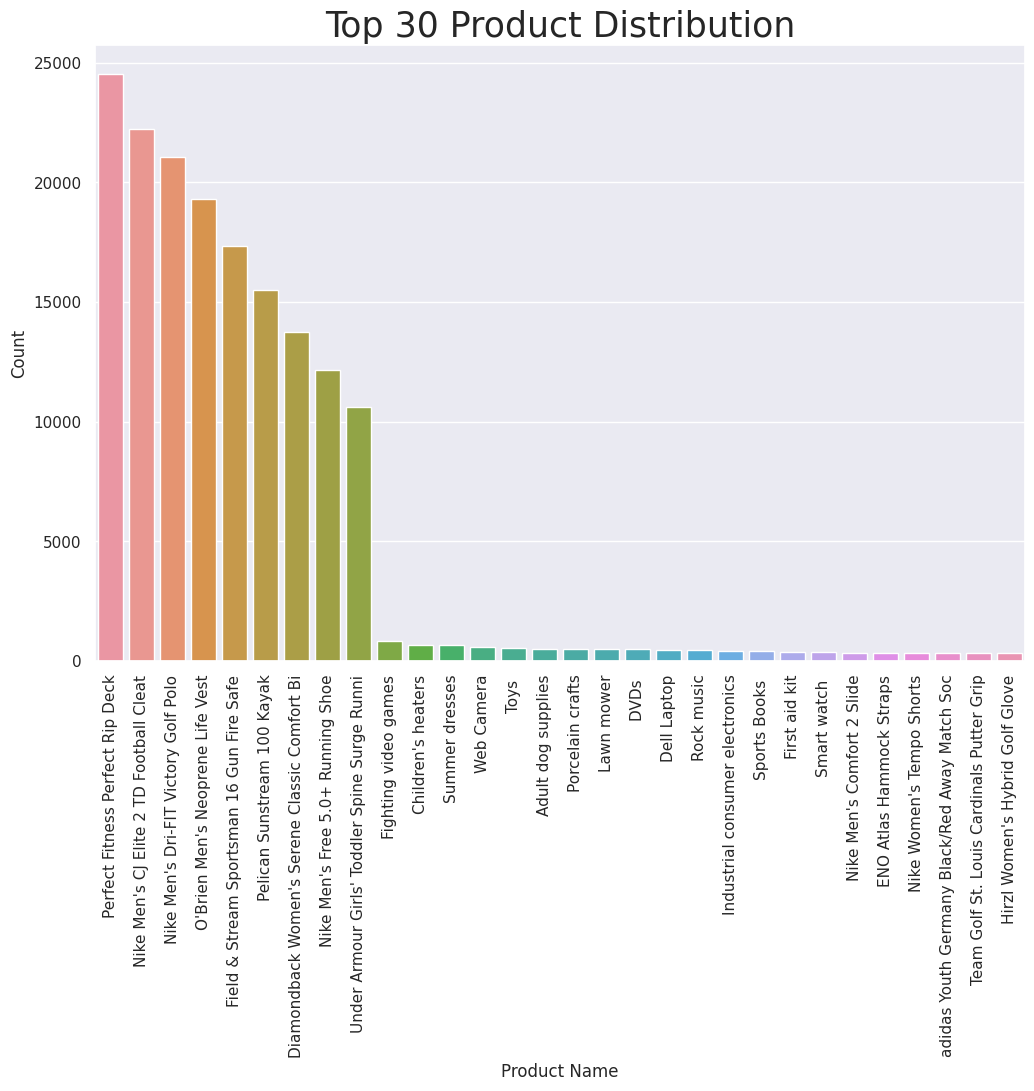

In [ ]:
# 가장 많이 팔린 상품 30
product_counts = data['product_name'].value_counts().sort_values(ascending=False).head(30)

# 막대그래프 그리기
plt.figure(figsize=(12,5))
sns.barplot(x=product_counts.index, y=product_counts.values)
plt.xticks(rotation='vertical')
plt.title('Top 30 Product Distribution', fontsize=25)
plt.ylabel('Count')
plt.xlabel('Product Name')
plt.grid(False)
plt.show()

- Perfect Fitness Perfect Rip Deck 가 가장 많이 팔린 제품이다.
- 뿐만 아니라 상위 9개 상품은 다른 제품에 비교했을 때 압도적으로 많이 판매된 것을 알 수 있다.
- 이는 위 카데고리 별 데이터와 비교해보았을 때, 많이 팔린 상품이 각 카테고리의 주력 상품이라고 해석할 수 있으므로, 별다른 해석을 진행하기 어렵다.
- 따라서 판매량이 아닌 카테고리와 이익간의 관계를 파악해보는 것이 중요하다.

#### 카테고리별 수익성 분석

**가설 검정**
- H0 : 다양한 제품 범주 간 주문 수익성에 차이가 없다
- H1 :  특정 제품 범주는 다른 제품 범주보다 수익성이 높다

In [ ]:
from scipy import stats

# 제품 카테고리 별 데이터 그룹화
product_groups = data2.groupby("product_category_id")

# 일원 분산분석 검정 실시 -> 제품군 간 주문당 평균 이익 비교
f_stat, p_value = stats.f_oneway(*[group['order_profit_per_order'] for name, group in product_groups])

alpha = 0.05

print("가설 : 제품 카테고리와 Order Profitability간의 관계")
print("F-statistic:", f_stat)
print("p-value:", p_value)

가설 : 제품 카테고리와 Order Profitability간의 관계
F-statistic: 50.753045450066324
p-value: 0.0


p-value가 0.05보다 작으므로 귀무가설을 기각한다. 즉, 특정 제품의 카테고리는 다른 제품 카테고리보다 수익성이 높다.


#### 수익성 높은 상품 분석

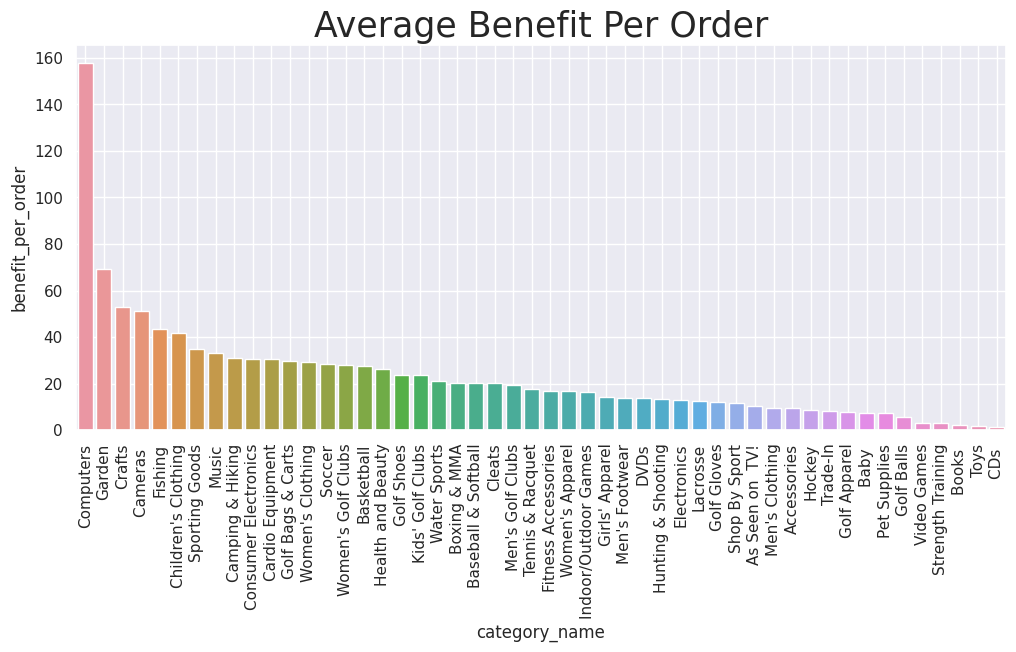

In [ ]:
# 가장 수익을 많이 낸 항목
average_benefit_per_order = data.groupby('category_name')['benefit_per_order'].mean().reset_index()

# benefit 순으로 데이터를 내림차순 정렬
average_benefit_per_order = average_benefit_per_order.sort_values(by='benefit_per_order', ascending=False)

# 막대그래프 그리기
plt.figure(figsize=(12,5))
sns.barplot(x='category_name', y='benefit_per_order', data=average_benefit_per_order)
plt.xticks(rotation=90)
plt.title('Average Benefit Per Order', fontsize=25)
plt.grid(False)
plt.show()

Computers 항목이 가장 압도적으로 수익이 발생하였고, 가장 적은 수익을 낸 카테고리는 CDs였다. 따라서 CDs/Toys/Books와 같은 카테고리는 추가적인 개선 또는 판매 중단이 이루어지는 편이 회사에 더 좋을 것이라고 조언할 수 있다

In [ ]:
best_products_profit_ratio = data.groupby("product_name").order_item_profit_ratio.mean().sort_values(ascending=False).head(30)
best_products_profit_ratio

product_name
Polar FT4 Heart Rate Monitor                     0.239833
Bowflex SelectTech 1090 Dumbbells                0.233000
Diamondback Boys' Insight 24 Performance Hybr    0.225517
Elevation Training Mask 2.0                      0.194054
MDGolf Pittsburgh Penguins Putter                0.192264
Ogio Race Golf Shoes                             0.191475
Bag Boy M330 Push Cart                           0.184493
Merrell Men's All Out Flash Trail Running Sho    0.176588
adidas Brazuca 2014 Official Match Ball          0.175538
TaylorMade White Smoke IN-12 Putter              0.169206
Glove It Women's Mod Oval Golf Glove             0.167148
Bag Boy Beverage Holder                          0.164265
Toys                                             0.161928
LIJA Women's Button Golf Dress                   0.156053
Team Golf Pittsburgh Steelers Putter Grip        0.155593
The North Face Women's Recon Backpack            0.155263
TaylorMade Women's RBZ SL Rescue                 0.155000
T

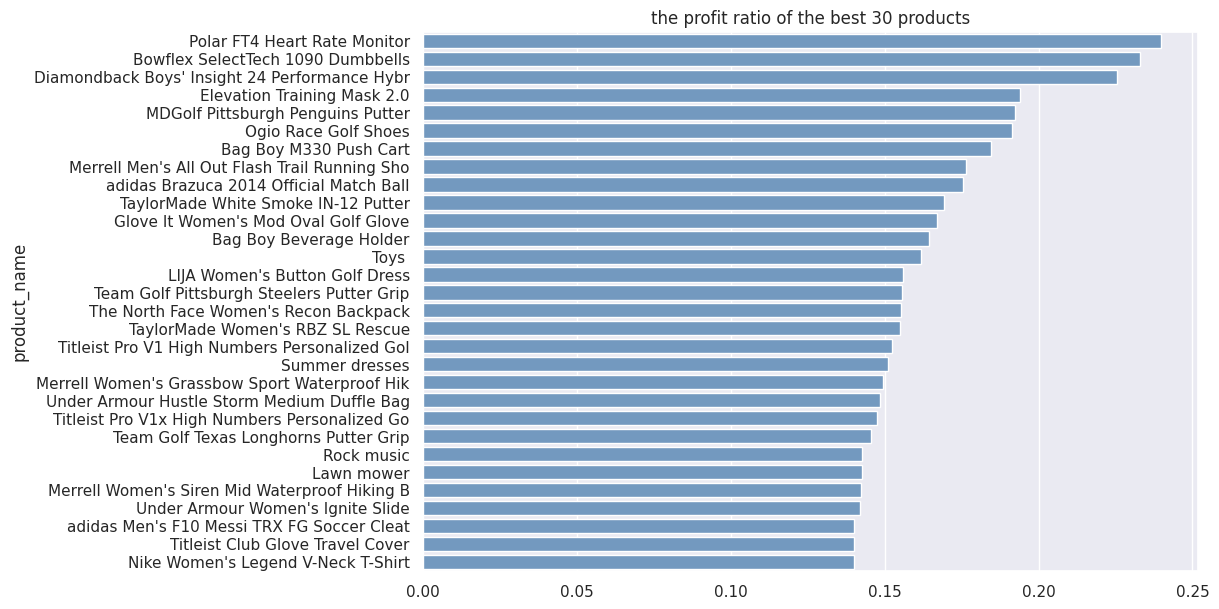

In [ ]:
plt.figure(figsize=(10,7))

sns.barplot(x= best_products_profit_ratio.values, y = best_products_profit_ratio.index, color ="#6699cc")
plt.title("the profit ratio of the best 30 products")
plt.grid(False)
plt.show()

가장 높은 이익을 보인 3가지 항목 모두, 판매 순위 리스트 30 순위권에 없는 것으로 확인되었다. 따라서, 이 3가지 항목은 적은 판매량으로도 높은 수익을 올릴 수 있는 상품이므로, 판매량 자체를 올릴 수 있는 할인이나 추가적인 대안을 통해 판매량을 올릴 수 있도록 노력해야 한다.

#### 수익성 낮은 상품 분석

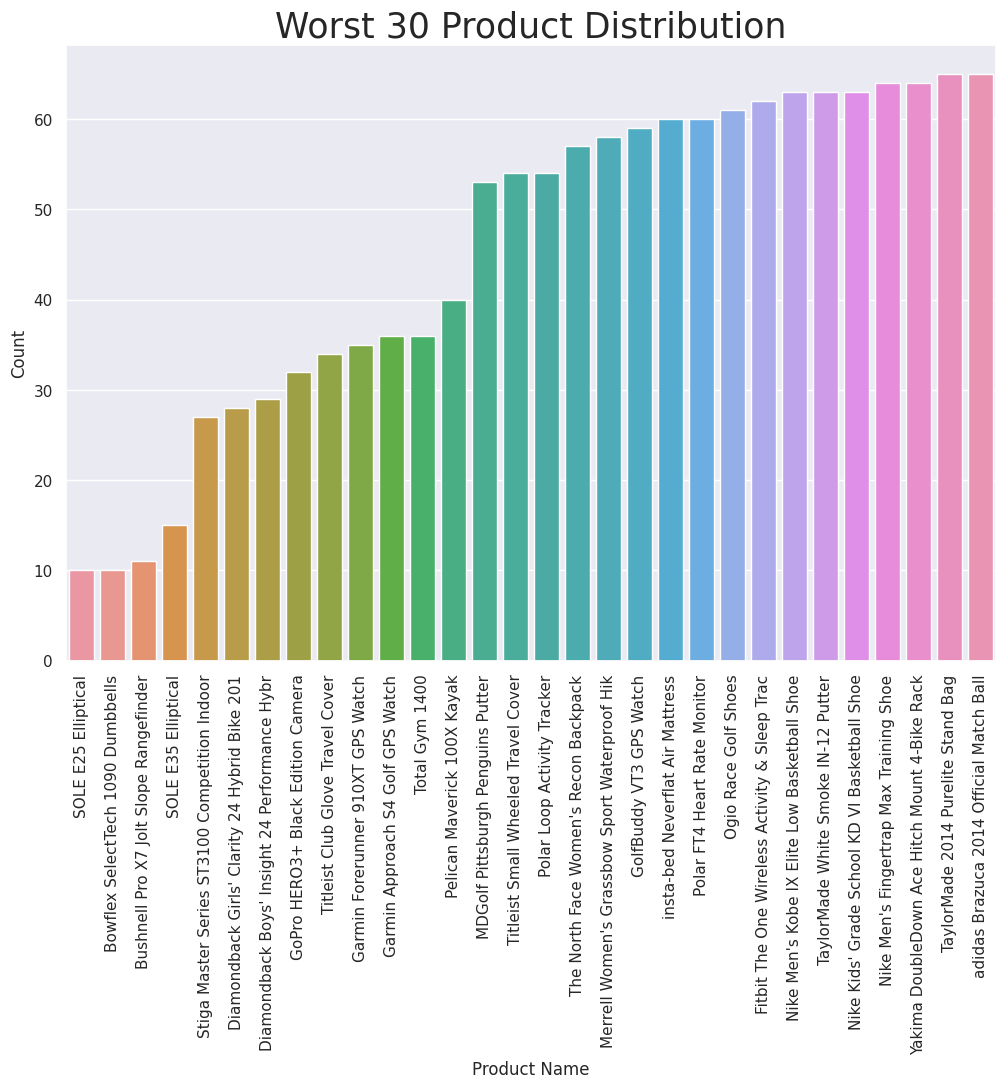

In [ ]:
# 가장 안팔리는 상품 30
product_counts2 = data['product_name'].value_counts().sort_values(ascending=True).head(30)

# 막대그래프 그리기
plt.figure(figsize=(12,5))
sns.barplot(x=product_counts2.index, y=product_counts2.values)
plt.xticks(rotation='vertical')
plt.title('Worst 30 Product Distribution', fontsize=25)
plt.ylabel('Count')
plt.xlabel('Product Name')
plt.grid(False)
plt.show()

SOLE E25 Elliptical 이 가장 안팔린 제품이다.

In [ ]:
worst_products_profit_ratio = data.groupby("product_name").order_item_profit_ratio.mean().sort_values().head(30)
worst_products_profit_ratio

product_name
SOLE E25 Elliptical                             -0.036000
SOLE E35 Elliptical                             -0.030000
Bushnell Pro X7 Jolt Slope Rangefinder          -0.024545
GoPro HERO3+ Black Edition Camera                0.015000
Diamondback Girls' Clarity 24 Hybrid Bike 201    0.037857
Garmin Forerunner 910XT GPS Watch                0.038571
Stiga Master Series ST3100 Competition Indoor    0.049259
Cleveland Golf Women's 588 RTX CB Satin Chrom    0.052143
Men's gala suit                                  0.052981
Polar Loop Activity Tracker                      0.060000
GolfBuddy VT3 GPS Watch                          0.061356
TaylorMade 2014 Purelite Stand Bag               0.063846
Nike Men's Free TR 5.0 TB Training Shoe          0.064853
ENO Atlas Hammock Straps                         0.074768
Sports Books                                     0.079062
Hirzl Men's Hybrid Golf Glove                    0.081170
Pelican Maverick 100X Kayak                      0.082750
C

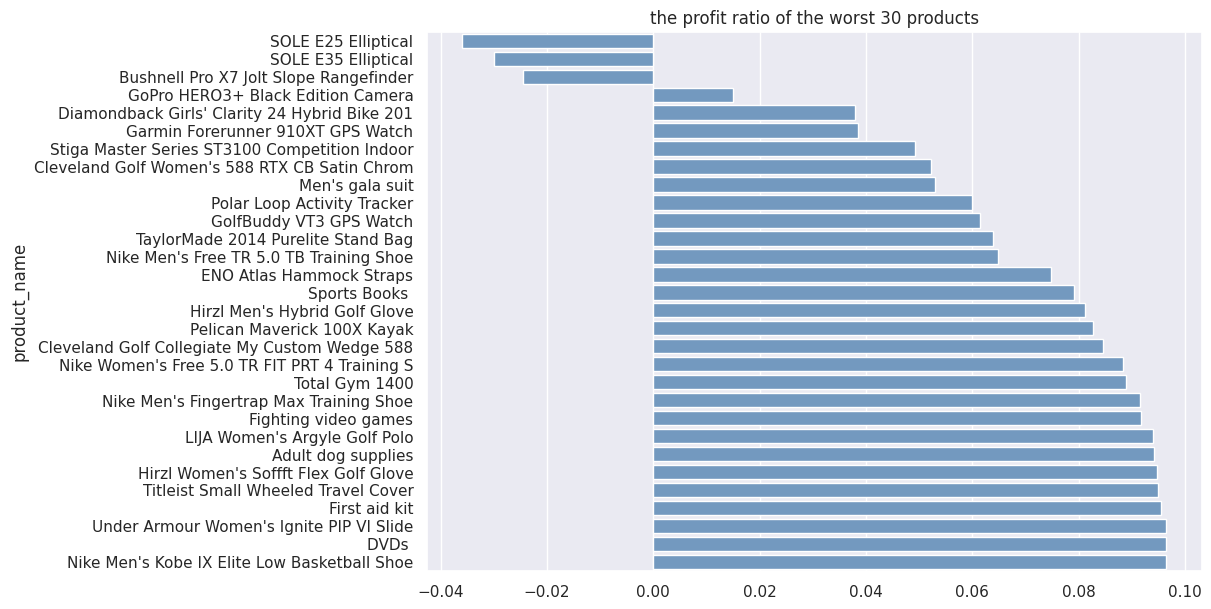

In [ ]:
plt.figure(figsize=(10,7))

sns.barplot(x= worst_products_profit_ratio.values, y = worst_products_profit_ratio.index, color ="#6699cc")
plt.title("the profit ratio of the worst 30 products")
plt.grid(False)
plt.show()

SOLE E35 Elliptical,SOLE E25 Elliptical,Bushnell Pro X7 Jolt Slope Rangefinder 3개의 항목은 판매하면서 오히려 손실이 발생함을 확인할 수 있었다.
이 3개의 손실 제품에 대한 추가적인 조사가 필요하다고 판단하였다.

In [ ]:
# 3개의 손실 제품에 대한 조사
data_3_worst = data.query("product_name==['SOLE E35 Elliptical','SOLE E25 Elliptical','Bushnell Pro X7 Jolt Slope Rangefinder'] & profit_or_lose =='lose'")
data_3_worst[['product_name','category_name',"delivery_status","customer_country","order_country",'order_item_discount_rate','order_profit_per_order']].style.background_gradient(cmap ='afmhot')

,product_name,category_name,delivery_status,customer_country,order_country,order_item_discount_rate
171809,SOLE E25 Elliptical,Basketball,Late delivery,EE. UU.,Alemania,0.120000
171917,SOLE E35 Elliptical,Strength Training,Advance shipping,Puerto Rico,Francia,0.160000
171949,SOLE E25 Elliptical,Basketball,Late delivery,EE. UU.,Alemania,0.100000
171958,SOLE E35 Elliptical,Strength Training,Shipping on time,Puerto Rico,Italia,0.150000
172013,SOLE E25 Elliptical,Basketball,Late delivery,EE. UU.,Alemania,0.060000
172033,Bushnell Pro X7 Jolt Slope Rangefinder,Kids' Golf Clubs,Advance shipping,Puerto Rico,Alemania,0.050000
172041,Bushnell Pro X7 Jolt Slope Rangefinder,Kids' Golf Clubs,Late delivery,Puerto Rico,Francia,0.040000
172045,Bushnell Pro X7 Jolt Slope Rangefinder,Kids' Golf Clubs,Shipping canceled,Puerto Rico,Francia,0.020000
172142,SOLE E35 Elliptical,Strength Training,Late delivery,EE. UU.,Reino Unido,0.050000


이 3가지 항목모두 판매량도 매우 저조하고, 손실이 발생하였다는 것이 공통점이다. 따라서, 3가지 항목 모두 추가적인 개선, 또는 판매 중단하는 것이 이익을 위해 바람직하다고 판단하였다.

### 3) 고객 구분과 Order Profitability와의 관계

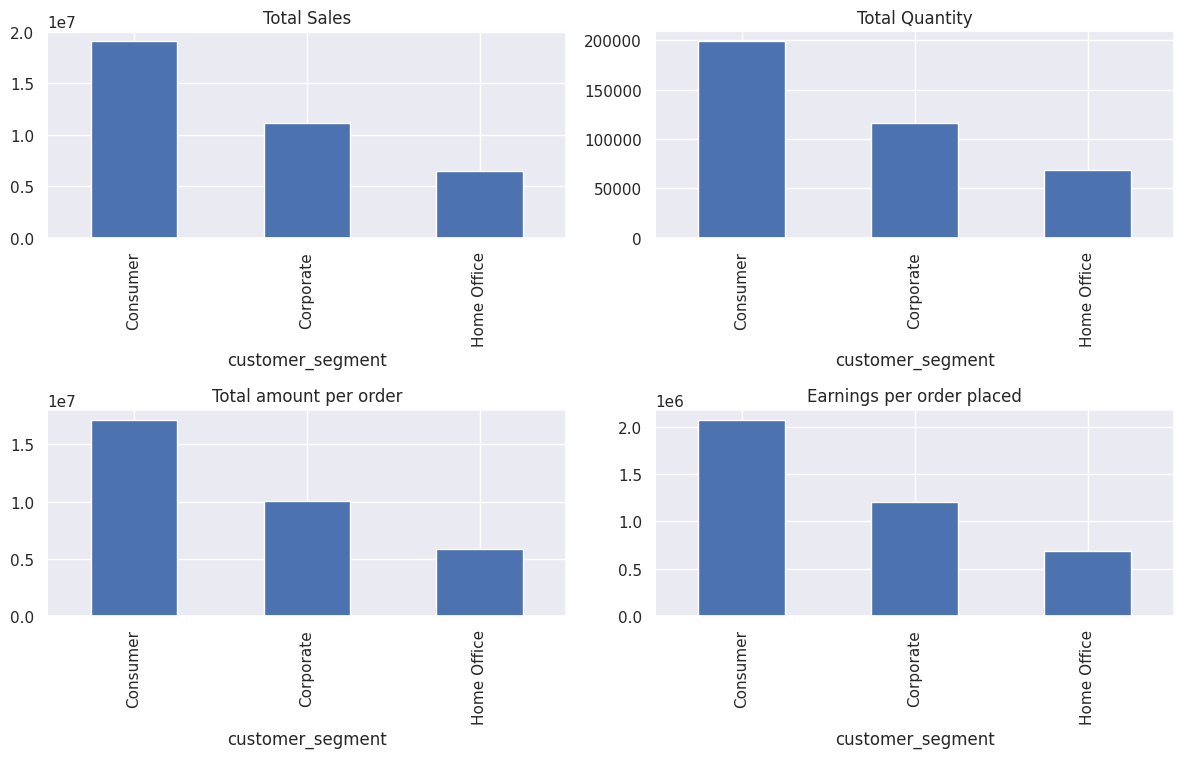

In [ ]:
import plotly.express as px
Customer=data.groupby('customer_segment')

plt.figure(figsize=(8,8))
plt.subplot(4, 2, 1)
Customer['sales'].sum().sort_values(ascending=False).plot.bar(figsize=(12,14), title="Total Sales")

plt.subplot(4, 2, 2)
Customer['order_item_quantity'].sum().sort_values(ascending=False).plot.bar(figsize=(12,14), title="Total Quantity")

plt.subplot(4, 2, 3)
Customer['order_item_total'].sum().sort_values(ascending=False).plot.bar(figsize=(12,14), title="Total amount per order")

plt.subplot(4, 2, 4)
Customer['benefit_per_order'].sum().sort_values(ascending=False).plot.bar(figsize=(12,14), title="Earnings per order placed")

plt.tight_layout()
plt.show()

data_Customer_Segment=data.groupby(['customer_segment'])['order_id'].count().reset_index(name='order_item_quantity').sort_values(by= 'order_item_quantity', ascending= False)
px.pie(data_Customer_Segment, values='order_item_quantity', names= 'customer_segment' , title= 'Number of Orders per Customer Segments',
       color='customer_segment',
       color_discrete_map={'Consumer':'darkblue','Corporate':'cyan',Home Office':'royalblue'})

In [ ]:
# 고객 구분에 따른 shipping mode 선택
shipping_mode_and_customer_category = data.groupby(['shipping_mode', 'customer_segment'])['order_id'].count().reset_index(name='Number of Orders')

fig = px.bar(shipping_mode_and_customer_category, x='customer_segment', y='Number of Orders', color='shipping_mode',
             title='Number of Orders by Shipping Mode and Customer Segment')

fig.show()

고객 구분에 따른 order profitability 가설 검정
- 그룹과 order profitability 사이에 유의한 관계가 있다?

In [ ]:
# #Conducting a one-way ANOVA test to compare the mean order profit per order between the shipping mode groups
# f_stat, p_value = stats.f_oneway(*[group['order_profit_per_order'] for name, group in Customer])

# alpha = 0.05

# print("Hypothesis 5: Impact of shipping mode on order profitability")
# print("F-statistic:", f_stat)
# print("p-value:", p_value)

# if p_value < alpha:
#     print("Reject the null hypothesis")
# else:
#     print("Fail to reject the null hypothesis")

검정 결과, consumer 그룹에 따른 profitability 차이는 없다

검정 결과, consumer 그룹에 따른 profitability 유의미한 관계는 없다

일반 소비자 50, 기업 30, 공공20 비율 일반 소비자에 가까워질수록 주문량, 매출, 주문 당 순이익 증가, 히트맵 전체데이터에서 매출과 마진율이 상관관계가 없던 것에 반해, 각 구분을 분리해서 보니 일반 소비자는 양의 상관관계 모든 소비자가 절반 이상 Stardard Class, 낮은 배송비를 선호하는 경향 + first,second late 비율이 높아 소비자들도 신뢰하지 못해 기피

배송 개선 + 배송비 쿠폰 등으로 consumer 부분에 집중해야

### 4) shipping mode와 order profitability의 관계



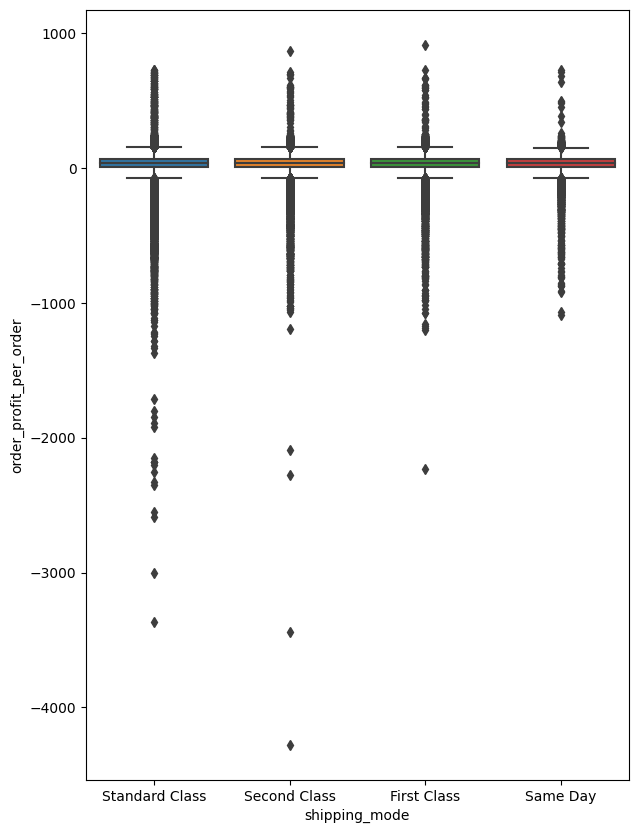

In [ ]:
# Filter relevant columns for analysis
data_delivery = data[['shipping_mode', 'order_profit_per_order']]

# Set figure size
plt.figure(figsize=(7, 10))

# Plot the relationship between shipping mode and order profit per order
sns.boxplot(x='shipping_mode', y='order_profit_per_order', data=data_delivery)

# Show the plot
plt.show()

<Axes: xlabel='shipping_mode', ylabel='order_profit_per_order'>

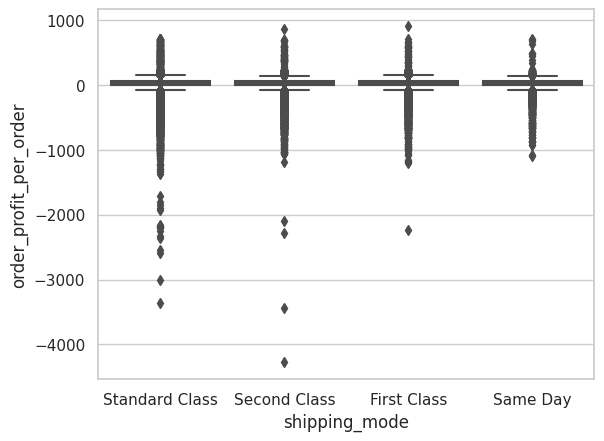

In [ ]:
# Filter relevant columns for analysis
data_delivery = data[['shipping_mode', 'order_profit_per_order']]

# Plot the relationship between shipping mode and order profit per order
sns.boxplot(x='shipping_mode', y='order_profit_per_order', data=data_delivery)

In [ ]:
negative_profit_rows = data[data['order_profit_per_order'] < 0]
count_negative_profit_rows = len(negative_profit_rows)

print(f"The number of rows with order_profit_per_order less than 0: {count_negative_profit_rows}")

The number of rows with order_profit_per_order less than 0: 33784


In [ ]:
# profit이 음수인 행들의 공통점 조사 필요...?
negative_profit_rows['product_category_id'].value_counts()

17    4590
18    4169
24    3923
46    3617
45    3209
      ... 
2       24
10      18
16      14
4       11
34       6
Name: product_category_id, Length: 51, dtype: int64

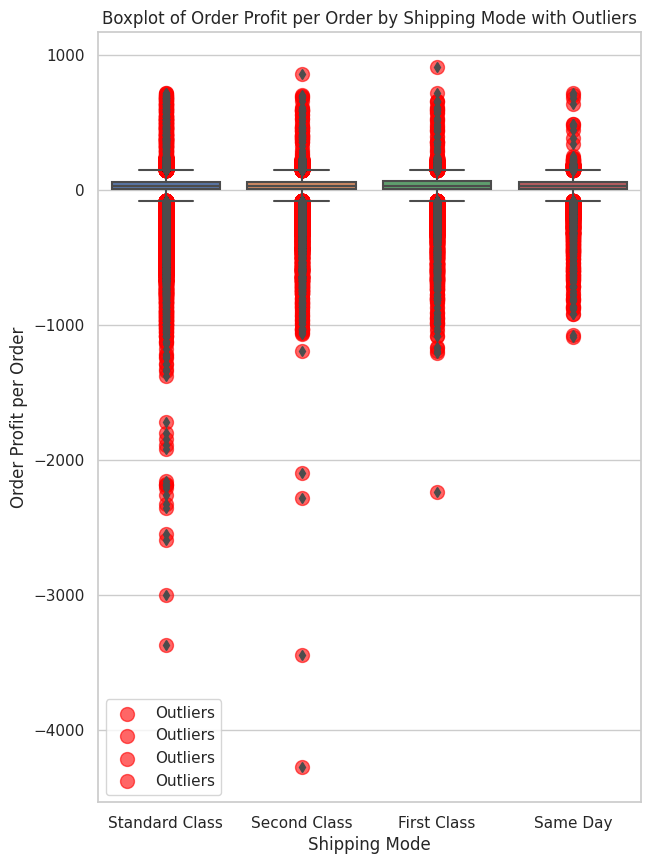

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter relevant columns for analysis
data_delivery = data[['shipping_mode', 'order_profit_per_order']]

# Create a boxplot
sns.set(style="whitegrid")
# Set figure size
plt.figure(figsize=(7, 10))

# Plot the relationship between shipping mode and order profit per order
sns.boxplot(x='shipping_mode', y='order_profit_per_order', data=data_delivery)

# Identify and plot outliers
for mode in data_delivery['shipping_mode'].unique():
    subset = data_delivery[data_delivery['shipping_mode'] == mode]['order_profit_per_order']
    q1 = subset.quantile(0.25)
    q3 = subset.quantile(0.75)
    iqr = q3 - q1

    # Identify outliers
    outliers = (subset < (q1 - 1.5 * iqr)) | (subset > (q3 + 1.5 * iqr))

    # Plot outliers
    plt.scatter([data_delivery['shipping_mode'].unique().tolist().index(mode)] * sum(outliers),
                subset[outliers], color='red', marker='o', s=100, alpha=0.6, label='Outliers')

plt.title('Boxplot of Order Profit per Order by Shipping Mode with Outliers')
plt.xlabel('Shipping Mode')
plt.ylabel('Order Profit per Order')

plt.legend()
plt.show()

가설 검정
귀무가설: shipping mode에 따른 유의미한 order profitability의 차이가 없다
대립가설: shipping mode에 따른 유의미한 order profitability의 차이가 있다

In [ ]:
Shipping=data.groupby('shipping_mode')

#Conducting a one-way ANOVA test to compare the mean order profit per order between the shipping mode groups
f_stat, p_value = stats.f_oneway(*[group['order_profit_per_order'] for name, group in Shipping])

alpha = 0.05

print("Hypothesis 5: Impact of shipping mode on order profitability")
print("F-statistic:", f_stat)
print("p-value:", p_value)

if p_value < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

Hypothesis 5: Impact of shipping mode on order profitability
F-statistic: 1.979181710886423
p-value: 0.11469269801389084
Fail to reject the null hypothesis


In [ ]:
data['order_date_dateorders'].tail(3)

180516    2018-01-31 22:56:00
180517    2018-01-31 23:17:00
180518    2018-01-31 23:38:00
Name: order_date_dateorders, dtype: object

P - value 0.05이상, 데이터 상에서 shipping mode와 order profitablity 사이 유의미한 관계가 없다

이미 주문이 들어온 건들로만 비교를 하기에 단순 P-value 판별로는 연관은 없으나
1. 값싼 배송비를 위해 Starndard Class를 선호
2. 배송비를 부담하고 first,second calss를
   선택하더라도 late 비율이 높음
3. 결과적으로 절반 이상 늦은 배송
   - 리드타임 손해, 경비 소요, 고객 불만 증가,
   잠재 수요 확보 실패
   데이터에 담겨 있지 않은 외부적 우려사항 많음

(실제 관련 사례 기사 찾아서 첨부하면 이해가 더 편할 듯)

In [ ]:
# shipping_mode에 따른 주문 수
data_Shipping_Mode = data.groupby(['shipping_mode'])['order_id'].count().reset_index(name='order_item_quantity').sort_values(by='order_item_quantity', ascending=False)

# 파이 차트 시각화
fig = px.pie(data_Shipping_Mode, values='order_item_quantity', names='shipping_mode', title='Shipping Mode',
             color='shipping_mode',
             color_discrete_map={'Standard Class': '#9ECAE1',  # 파란색
                                 'Second Class': '#Fdae61',  # 주황색
                                 'First Class': '#fee08b',  # 노란색
                                 'Same Day': '#d7e9b4'})  # 초록색

# 그래프 표시
fig.show()

## 가설 검증 (사용 X)
  - 'shipping mode에서 높은 등급일수록 배송 지연 위험이 낮다'에 대한 가설을 검증

In [ ]:
# shipping mode 카테고리 숫자로 바꾸기
data['shipping_mode_2'] = data['shipping_mode'].replace(['Same Day', 'First Class', 'Second Class', 'Standard Class'], [1,2,3,4])

In [ ]:
# 시각화 하기
cross_table = pd.crosstab(data_subset['shipping_mode_2'], data_subset['late_delivery_risk'])
cross_table

NameError: ignored

In [ ]:
# shipping_mode와 late_delivery_risk 두 변수 간의 통계성 유의 판단

import seaborn as sns
from scipy.stats import chi2_contingency

# 데이터프레임에서 필요한 컬럼만 추출
data_subset = data[['shipping_mode_2', 'late_delivery_risk']]

# 카이제곱 검정을 통한 통계적 유의성 검정
chi2, p, _, _ = chi2_contingency(cross_table)

# 결과 출력
print(f"Chi-Square Value: {chi2}")
print(f"P-Value: {p}")

# 가설 검정 결과 해석
alpha = 0.05  # 유의수준 0.05 설정
if p < alpha:
    print("귀무가설을 기각합니다. 따라서, Shipping mode와 late_delivery_risk 간에는 통계적으로 유의한 관계가 있을 수 있습니다.")
else:
    print("귀무가설을 기각하지 못합니다. 따라서, Shipping mode와 late_delivery_risk 간에는 통계적으로 유의한 관계가 있을 가능성이 적습니다.")

NameError: ignored

귀무가설이 기각되며 두 변수 간에는 통계적으로 유의미하다는 결과를 얻을 수 있다.

In [ ]:
# 'shipping mode에서 높은 등급일수록 배송 지연 위험이 낮다'에 대한 가설을 검증

In [ ]:
data.head()

,Unnamed: 0,type,days_for_shipping_real,days_for_shipment_scheduled,benefit_per_order,sales_per_customer,delivery_status,late_delivery_risk,category_id,category_name,...,product_card_id,product_category_id,product_name,product_price,shipping_date_dateorders,shipping_mode,customer_full_name,shipping_mode_2,customer_id_str,unique_order
0,33833,CASH,2,4,88.790001,239.979996,Advance shipping,0,43,Camping & Hiking,...,957,43,Diamondback Women's Serene Classic Comfort Bi,299.980011,2015-01-03 00:00:00,Standard Class,MaryMalone,4,11599,1
1,77011,PAYMENT,3,4,91.180000,193.990005,Advance shipping,0,48,Water Sports,...,1073,48,Pelican Sunstream 100 Kayak,199.990005,2015-01-04 00:21:00,Standard Class,DavidRodriguez,4,256,3
2,109322,PAYMENT,3,4,68.250000,227.500000,Advance shipping,0,24,Women's Apparel,...,502,24,Nike Men's Dri-FIT Victory Golf Polo,50.000000,2015-01-04 00:21:00,Standard Class,DavidRodriguez,4,256,3
3,87884,PAYMENT,3,4,36.470001,107.889999,Advance shipping,0,18,Men's Footwear,...,403,18,Nike Men's CJ Elite 2 TD Football Cleat,129.990005,2015-01-04 00:21:00,Standard Class,DavidRodriguez,4,256,3
4,114915,CASH,5,4,33.590000,159.940002,Late delivery,1,46,Indoor/Outdoor Games,...,1014,46,O'Brien Men's Neoprene Life Vest,49.980000,2015-01-06 01:03:00,Standard Class,BrianWilson,4,8827,4


In [ ]:
data['customer_country'].value_counts()

EE. UU.        111146
Puerto Rico     69373
Name: customer_country, dtype: int64

## (2) Lead Time에 따른 분석

### 1) 국가에 따른 리드타임

1. 국가에 따른 리드타임 분석

  1) 국가별 주문수 시각화

  2) 국가별 주문의 이윤 시각화

  3) 고객의 국가에서 세계의 여러 지역으로 주문의 이동 노선에 따른 이익/손해 분석

    - customer_country : 고객이 구매한 국가
      (만약, 고객이 미국에서 제품을 주문했다면 해당 주문은 미국으로 기록)
    - order_region : 주문이 배달되는 세계 지역에 대한 목록


In [ ]:
# 필요 패키지 설치
%pip install pycountry-convert
!pip install googletrans==4.0.0-rc1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
import holoviews as hv
import plotly.graph_objects as go
import plotly.express as px
import pycountry_convert as pc
from googletrans import Translator

#### 국가별 주문수 시각화


In [ ]:
data_Region=data.groupby(['order_region'])['order_id'].count().reset_index(name='number_of_orders').sort_values(by= 'number_of_orders', ascending= True)
px.bar(data_Region, x='number_of_orders',y = 'order_region',color ='number_of_orders')

**지도 플롯 위하여 전처리**

In [ ]:
# order_country별 order_profit_per_order 계산한 dataframe data_geo
data_geo = data.groupby("order_country").order_profit_per_order.sum().sort_values().reset_index()
data_geo

,order_country,order_profit_per_order
0,Guinea-Bissau,-1448.720008
1,Taiwn,-1374.540018
2,Ruanda,-330.020066
3,Bosnia y Herzegovina,-327.380032
4,Mongolia,-286.229951
...,...,...
159,Brasil,186713.640355
160,Alemania,194827.080381
161,Mxico,303278.370637
162,Francia,327828.580099


In [ ]:
# !pip install pycountry_convert
# !pip install googletrans==4.0.0-rc1

In [ ]:
# 구글트랜스 라이브러리를 이용하여 발주국의 컬럼을 영어로 번역
from googletrans import Translator
translator = Translator()
data_geo["translated_order_country"] = data_geo.order_country.apply(lambda x : translator.translate(x, dest='en').text)

In [ ]:
data_geo

,order_country,order_profit_per_order,translated_order_country
0,Guinea-Bissau,-1448.720008,Guinea-Bissau
1,Taiwn,-1374.540018,Taean
2,Ruanda,-330.020066,Rwanda
3,Bosnia y Herzegovina,-327.380032,Bosnia y Herzegovina
4,Mongolia,-286.229951,Mongolia
...,...,...,...
159,Brasil,186713.640355,Brazil
160,Alemania,194827.080381,Germany
161,Mxico,303278.370637,Mexico
162,Francia,327828.580099,France


In [ ]:
# 번역 후 국가의 알려지지 않은 이름을 수정하는 함수 설정
def country_name_changer(name,newname):
    data_geo["translated_order_country"]=data_geo["translated_order_country"].replace(name,newname)

In [ ]:
country_name_changer(["Bosnia y Herzegovina","Republic of Gambia","Belice",'Sahara Occidental',"Surinam","Butn",
                      "Republic of Congo","Sierra Leona","Botsana","Guadalupe","Moldavia","Swiss","Myanmar (Burmania)",
                      "Rumania","Irak","Democratic Republic of Congo","Filipinas","Türkiye","The Savior","Italia",
                      "Y i don’t mention","French Guayana",'Abandon',"Renovation","CHIPP","Lesoto","Botana",
                      "Y i not mentioned","Kyrguistan","Finlandia","Myanmar (Birmania)","Space",'Taean','Gabn',
                      'Ethiopian','Lbano','Tnez','Afghan','Benn','New Guinea Pope','Kirguistan',
                      'UZBEKISTAN','Wanna','Sudn','Hunger','Cameron','Banglads','Arabia Saud',
                      'sharp','Jain','Blgica','Per','Irn','Panaman','Low passes','Turqua','Sword'],
                     ["Bosnia and Herzegovina","Gambia","Belize","Western Sahara","Suriname","Bhutan",
                      "Congo","Sierra Leone","Botswana","Guadeloupe","Moldova","Switzerland","Myanmar",
                      "Romania","Iraq","Congo","Philippines","Turkey","El Salvador","Italy",
                      "Djibouti","French Guiana","Bahrain","Tajikistan","Chile","Lesotho","Bhutan",
                      "Dominica","Kyrgyzstan","Finland","Myanmar","Switzerland",'Taiwan','Gabon',
                      'Ethiopia','Lebanon','Tunisia','Afghanistan','Benin','Papua New Guinea','Kyrgyzstan',
                      'Uzbekistan','Niger','Sudan','Hungary','Cameroon','Bangladesh','Saudi Arabia',
                      'Haiti','Japan','Belgium','Peru','Iran','Panama','Netherlands','Turkey','Spain'])

In [ ]:
# pycountry_convert 라이브러리를 사용하여 국가의 iso3에 대한 새로운 열을 adding
# 나중에 plotlibrary가 국가 이름을 이해할 수 있도록 합니다
import pycountry_convert as pc
data_geo["order_country_iso3"] = data_geo['translated_order_country'].apply(lambda x:pc.country_name_to_country_alpha3(x,))

data_geo

,order_country,order_profit_per_order,translated_order_country,order_country_iso3
0,Guinea-Bissau,-1448.720008,Guinea-Bissau,GNB
1,Taiwn,-1374.540018,Taiwan,TWN
2,Ruanda,-330.020066,Rwanda,RWA
3,Bosnia y Herzegovina,-327.380032,Bosnia and Herzegovina,BIH
4,Mongolia,-286.229951,Mongolia,MNG
...,...,...,...,...
159,Brasil,186713.640355,Brazil,BRA
160,Alemania,194827.080381,Germany,DEU
161,Mxico,303278.370637,Mexico,MEX
162,Francia,327828.580099,France,FRA


In [ ]:
# 국가 별 주문 수 합산
number_of_orders = data.groupby(['order_country'])['order_id'].count().reset_index(name='number_of_orders').sort_values(by='number_of_orders', ascending=False)
number_of_orders

,order_country,number_of_orders
48,Estados Unidos,24840
53,Francia,13222
101,Mxico,13172
2,Alemania,9564
8,Australia,8497
...,...,...
132,Shara Occidental,2
44,Eritrea,2
82,Kuwait,2
24,Burundi,1


In [ ]:
# order_country열의 알파벳 순으로 datatframe 정렬
number_of_orders = number_of_orders.sort_values(by='order_country')
number_of_orders

,order_country,number_of_orders
0,Afganistn,163
1,Albania,37
2,Alemania,9564
3,Angola,306
4,Arabia Saud,860
...,...,...
159,Vietnam,757
160,Yemen,71
161,Yibuti,31
162,Zambia,266


In [ ]:
# order_country열의 알파벳 순으로 datatframe 정렬
data_geo = data_geo.sort_values(by='order_country')

# 인덱스 번호 reset
data_geo.reset_index(inplace=True)
data_geo

,index,order_country,order_profit_per_order,translated_order_country,order_country_iso3
0,60,Afganistn,1223.730024,Afghanistan,AFG
1,65,Albania,1660.779998,Albania,ALB
2,160,Alemania,194827.080381,Germany,DEU
3,33,Angola,361.800030,Angola,AGO
4,113,Arabia Saud,11735.630099,Saudi Arabia,SAU
...,...,...,...,...,...
159,122,Vietnam,16450.940116,Vietnam,VNM
160,62,Yemen,1486.780020,Yemen,YEM
161,61,Yibuti,1239.000008,Dominica,DMA
162,88,Zambia,4120.770003,Zambia,ZMB


In [ ]:
# 두 개의 데이터 프레임 합치기
data_geo_2 = pd.concat([data_geo,number_of_orders], axis=1)
data_geo_2 = data_geo_2.drop('order_country', axis=1)
data_geo_2

,index,order_profit_per_order,translated_order_country,order_country_iso3,number_of_orders
0,60,1223.730024,Afghanistan,AFG,163
1,65,1660.779998,Albania,ALB,37
2,160,194827.080381,Germany,DEU,9564
3,33,361.800030,Angola,AGO,306
4,113,11735.630099,Saudi Arabia,SAU,860
...,...,...,...,...,...
159,122,16450.940116,Vietnam,VNM,757
160,62,1486.780020,Yemen,YEM,71
161,61,1239.000008,Dominica,DMA,31
162,88,4120.770003,Zambia,ZMB,266


In [ ]:
# Create choropleth map using Plotly
fig = px.choropleth(data_geo_2, locations='order_country_iso3', color='number_of_orders',
                    hover_name='translated_order_country',projection='natural earth', title='Interactive mape of Number of Orders per country',
                   color_continuous_scale="magma_r")
fig.show()

#### 국가별 이윤 시각화


In [ ]:
# 국가 별 이윤 합산
profit_of_orders = data.groupby(['order_country'])['order_id'].sum().reset_index(name='profit_of_orders').sort_values(by='profit_of_orders', ascending=False)
profit_of_orders

,order_country,profit_of_orders
48,Estados Unidos,901775056
53,Francia,509363745
101,Mxico,413972419
2,Alemania,369347347
8,Australia,289671490
...,...,...
62,Guinea Ecuatorial,92855
132,Shara Occidental,88690
82,Kuwait,83526
24,Burundi,48842


In [ ]:
# order_country열의 알파벳 순으로 profit_of_orders datatframe 정렬 (data_geo dataframe은 위에서 이미 정렬해서 생략)
profit_of_orders = profit_of_orders.sort_values(by='order_country')
profit_of_orders

# 두 데이터프레임 합치기
data_geo_3 = pd.concat([data_geo,profit_of_orders], axis=1)

# 두 번 반복되는 'order_country'열 삭제하기
data_geo_3 = data_geo_3.drop('order_country', axis=1)
data_geo_3

,index,order_profit_per_order,translated_order_country,order_country_iso3,profit_of_orders
0,60,1223.730024,Afghanistan,AFG,5585666
1,65,1660.779998,Albania,ALB,1750091
2,160,194827.080381,Germany,DEU,369347347
3,33,361.800030,Angola,AGO,14204140
4,113,11735.630099,Saudi Arabia,SAU,39691239
...,...,...,...,...,...
159,122,16450.940116,Vietnam,VNM,25554438
160,62,1486.780020,Yemen,YEM,3297020
161,61,1239.000008,Dominica,DMA,1442814
162,88,4120.770003,Zambia,ZMB,12298879


In [ ]:
# 국가별 주문의 이윤 시각화

fig = px.choropleth(data_geo_3, locations='order_country_iso3', color='profit_of_orders',
                    hover_name='translated_order_country',projection='natural earth', title='Interactive mape of Profit of Orders per country',
                   color_continuous_scale="magma_r")
fig.show()

물류센터로 결과 엮기

#### 고객의 국가에서 세계의 여러 지역으로 주문의 이동 노선에 따른 이익/손해 분석

**손해가 발생한 노선**


In [ ]:
loss_data = data.query("profit_or_lose == 'lose'")

loss_data_flow = loss_data.groupby(["customer_country","order_region"]).order_profit_per_order.mean().reset_index()
loss_data_flow.columns =  ["customer_country","order_region","average lose per order"]
loss_data_flow["average lose per order"] = loss_data_flow["average lose per order"].apply(lambda x:round(x)*-1)
loss_data_flow.head()

,customer_country,order_region,average lose per order
0,EE. UU.,Canada,103
1,EE. UU.,Caribbean,109
2,EE. UU.,Central Africa,113
3,EE. UU.,Central America,114
4,EE. UU.,Central Asia,108


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
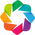

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning:

'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning:

'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.



:Sankey   [customer_country,order_region]   (average lose per order)

In [ ]:
hv.extension("bokeh")
sankey_diag = hv.Sankey(loss_data_flow)
sankey_diag.opts(cmap='Dark2',edge_color='customer_country',edge_line_width=0,node_alpha=0.5,
                 node_width=40,width=800, height=700, bgcolor="snow",
                 title="average lose per order from Customer's Country to the Regions of the world where are delivered")

**이익이 발생한 노선**

In [ ]:
profit_data = data.query("profit_or_lose == 'profit'")
profit_data_flow = profit_data.groupby(["customer_country","order_region"]).order_profit_per_order.mean().reset_index()
profit_data_flow.columns =  ["customer_country","order_region","average profit per order"]
profit_data_flow["average profit per order"] = profit_data_flow["average profit per order"].apply(lambda x:round(x))
profit_data_flow.head()

,customer_country,order_region,average profit per order
0,EE. UU.,Canada,51
1,EE. UU.,Caribbean,53
2,EE. UU.,Central Africa,52
3,EE. UU.,Central America,53
4,EE. UU.,Central Asia,50


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
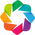

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning:

'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning:

'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.



:Sankey   [customer_country,order_region]   (average profit per order)

In [ ]:
hv.extension("bokeh")
sankey_diag = hv.Sankey(profit_data_flow)
sankey_diag.opts(cmap='Dark2',edge_color='customer_country',edge_line_width=0,node_alpha=0.5,
                 node_width=40,width=800, height=700, bgcolor="snow",
                 title="average profit per order from Customer's Country to the Regions of the world where are delivered")

- 이 두 개의 샌키 다이어그램을 분석한 결론은 주문이 이뤄지는 고객 국가와 전 세계적인 시장 간의 배송 동향에 대한 소중한 통찰력을 제공한다는 것입니다. 주문의 흐름을 출처에서 시장까지 세심하게 추적하여, 이익을 창출하거나 손실을 입는 제품에 대한 주문 당 평균 이익과 손실을 계산했습니다.

- 이 정보는 공급망을 최적화하려는 이해관계자들에게 중요합니다. 예를 들어, 미국에서 카리브 해 시장으로 배송되는 주문당 평균 이익 (53 달러)과 푸에르토리코에서 카리브 해 시장으로 배송되는 주문당 평균 이익 (51 달러)을 비교하고, 미국에서의 주문당 평균 손실 (109 달러)과 푸에르토리코에서의 손실 (124 달러)을 대조하면 명확한 패턴이 나타납니다.

- 이러한 결과를 고려할 때, 전략적인 접근은 미국에서 카리브 해 시장으로의 배송을 확대하고, 그곳에서의 이익이 높고 손실이 비교적 낮기 때문입니다. 반면에, 푸에르토리코에서 카리브 해 시장으로의 배송을 줄이는 것이 고려될 수 있습니다. 왜냐하면 평균 이익이 낮고 평균 손실이 높기 때문입니다.

- 총론적으로, 이러한 통찰력은 이해관계자들이 정보에 기반하여 결정을 내리고, 공급망의 효율성과 수익성을 향상시키기 위한 추가 연구를 수행할 수 있는 기반이 됩니다.

### 2) shipping mode에 따른 리드타임

위 차트를 통해 예정된 날짜에 배송되어야 하는 주문 중 2일로 예정된 배송은 주로 second 배송 모드와 관련이 있다. 따라서 지연된 배송 중에서 가장 많은 부분은 second class와 관련이 있음.


* 배송 모드 (예정된 출고일 기준):

   - Standard Class (4 Days): 4일로 예정된 배송
   - Second Class (2 Days): 2일로 예정된 배송으로, 해당 배송 모드에서 가장 많은 지연이 발생하고 있음.
   - First Class (1 Day): 1일로 예정된 배송.
   - Same Day (0 Day): 당일로 예정된 즉시 배송.

- Shipping mode(배송모드)
  : 제품이나 상품을 구매자에게 배송하는 방식(혹은 방법)

    - Standard Class : 표준 배송 서비스. 가장 일반적으로 사용되는 배송 옵션 중 하나로, 보통 비교적 합리적인 가격과 표준 배송 시간을 제공.

    - First Class : 빠른 배송 서비스. 이 클래스는 일반적으로 표준 배송보다 빠른 배송을 제공하며, 더 높은 운송료가 부과될 수 있음.

    - Second Class : 두 번째로 빠른 배송 서비스. 일반적으로 First Class에 비해 배송 시간이 조금 더 걸리며, 비교적 운송료가 더 낮을 수 있음.

    - Same Day (당일 배송): 주문한 날에 상품을 배송받을 수 있는 서비스. 가장 빠른 배송 옵션 중 하나이지만, 일반적으로 높은 추가 비용이 부과될 수 있음.





- delivery_status(배송 상태) : 주문된 상품이 어떤 상태에 있는지를 나타내는 정보
    - Advance Shipping(미리 배송):예상보다 빠름
    - Late Delivery (지연된 배송): 주문된 상품이 예정된 배송일보다 늦게 도착
    - Shipping Canceled (배송 취소): 주문된 상품의 배송이 취소
    - Shipping on Time (제시간에 배송): 주문된 상품이 예정된 배송일에 정확하게 도착




  - late_delivery_risk : 배송이 지연될 가능성 나타냄
    - 1 : 지연됨
    - 0 : 지연되지 않음

- 각 주문에서 배송이 늦어질 가능성이 가장 높은 지역을 이해하는 것이 큰 의미가 있다. 왜냐하면 배송 지연은 회사의 수익 손실로 이어질 수 있기 때문.

 따라서 네가지 측면에서 분석을 진행하고자 함.

 (1) 고위험 지역 식별
 (2) 배송 계획 최적화
 (3) 고객 만족도 유지
 (4) 수익 손실 방지


In [ ]:
# shipping mode에 따른 주문수량

# delivery_status(배송 상태) 에 따른 주문 수
data_Delivery = data.groupby(['delivery_status'])['order_id'].count().reset_index(name='order_item_quantity').sort_values(by='order_item_quantity', ascending=False)

# 파이 차트 시각화
fig = px.pie(data_Delivery, values='order_item_quantity', names='delivery_status', title='Delivery Status',
             color='delivery_status',
             color_discrete_map={'Advance shipping': '#9ECAE1',  # 파란색
                                 'Late delivery': '#Fdae61',  # 주황색
                                 'Shipping canceled': '#fee08b',  # 노란색
                                 'Shipping on time': '#d7e9b4'})  # 초록색

# 그래프 표시
fig.show()

위 차트는 배송 상태에 따른 주문수를 시각화 한 것이다.
전체 주문수의 약 54.8% 가량이 배송 지연,
23% 가량이 미리 배송, 17.8% 가량이 적기 배송, 4.3% 가량이 배송 취소 상태를 나타낸다.

-> 주문 수의 절반 이상이 배송이 지연되는 현상을 보이고 있다.

In [ ]:
# 각 배송 모드에서 주문이 어떤 배송 상태에 있는가

data["late_days"] = data.days_for_shipping_real - data.days_for_shipment_scheduled
total = data.groupby("shipping_mode", as_index = False).agg(count = ("shipping_mode", "count"))
total

ship_mode = data.groupby(["shipping_mode", "delivery_status"], as_index = False).agg(number = ("delivery_status", "count"),  late_delivery_risk = ("late_delivery_risk", "mean"), actual_days_for_shipping = ("days_for_shipping_real", "mean"), scheduled_days_for_shipping = ("days_for_shipment_scheduled", "mean"), total_item = ("order_item_quantity", "mean"), late_days = ("late_days", "mean"))

ship_mode = ship_mode.merge(total, on = "shipping_mode", how = "left")
ship_mode.rename(columns={'count': 'total_number'}, inplace=True)
ship_mode["percentage"] = ship_mode.number/ship_mode.total_number*100

x = ["First Class", "Same Day", "Second Class", "Standard Class"]
for y in x:
    mask = ship_mode[ship_mode["shipping_mode"] == y]
    mask = mask.pivot(index='shipping_mode', columns='delivery_status', values=['percentage'])
    exec(f"{y.lower().replace(' ', '_')} = mask")

ship_mode_graph = pd.concat([first_class, second_class, standard_class, same_day])

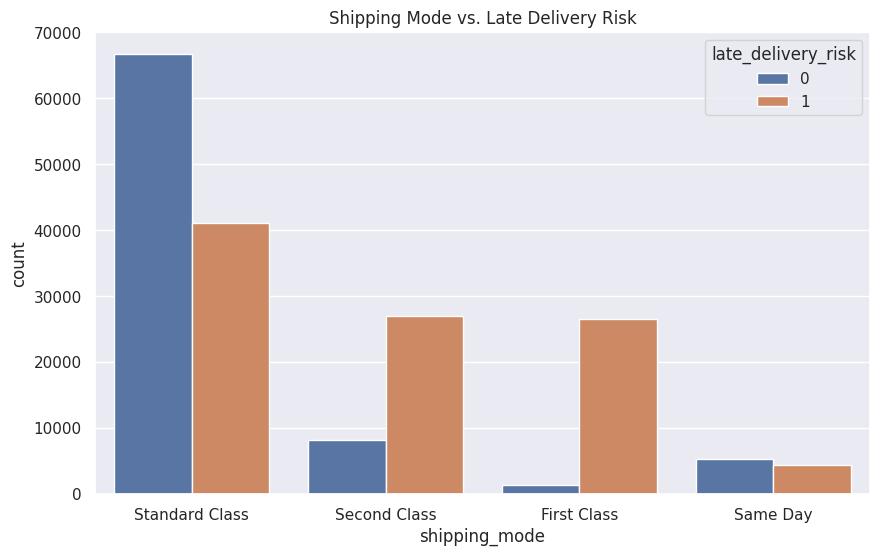

In [ ]:
# Shipping Mode vs. Late Delivery Risk 시각화

shipping_mode_leadtime = data[['shipping_mode', 'late_delivery_risk']]

plt.figure(figsize=(10, 6))
sb.countplot(x='shipping_mode', hue='late_delivery_risk', data=shipping_mode_leadtime)
plt.title('Shipping Mode vs. Late Delivery Risk')
plt.show()

# 이때, 1은 늦음, 0은 늦지않음

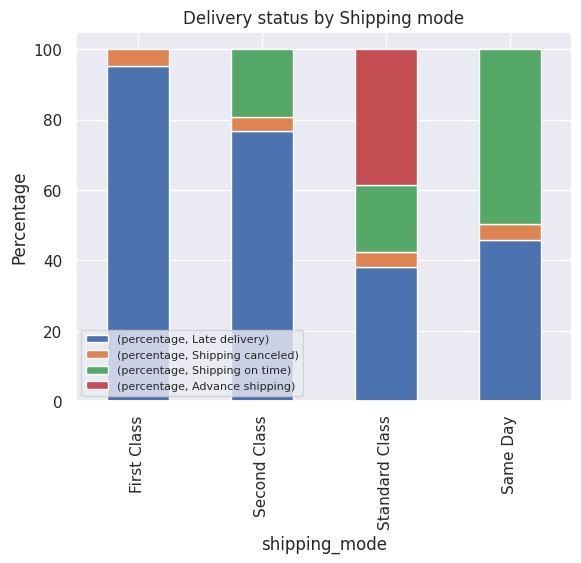

In [ ]:
ship_mode_graph.plot(kind='bar', stacked=True)
plt.xlabel('shipping_mode')
plt.ylabel('Percentage')
plt.title('Delivery status by Shipping mode')
plt.legend(loc='lower left', prop={'size': 8})

각 배송 모드와 배송 상태에 대한 통계 정보를 계산하고, 시각화를 한 bar 그래프이다.
차트를 통해 각 배송 모드에서의 주문이 어떤 배송 상태에 속하는지와 해당 비율을 확인할 수 있다.

  - first_class의 아이템의 경우 지연 배송 비율이 약 95%, second class 주문의 경우 약 77%의 비율을 갖는다.
      - 주문의 거의 절반 이상이 지연되고 있어 모든 배송 모드의 성과가 부족.
      - 고위험 first class 및 second class 아이템은 특히 높은 지연 배송 비율을 보이며, second class 주문도 상당한 수준의 지연이 발생하고 있음.
      - 고객 만족도 및 기업 이미지 영향과 고객 유지에 미치는 영향 또한 부정적으로 예상. 따라서 대처 전략의 필요성이 시급하다.

In [ ]:
# real_scheduled_gap
data['real_schedule_gap'] = data['days_for_shipping_real'] - data['days_for_shipment_scheduled']
data['real_schedule_gap'].describe()

# late_delivery_risk_2
# real_schedule_gap > 0 : 더 오래 걸림: 1
# real_schedule_gap <= 0 : 같거나 적게 걸림: 0
data['late_delivery_risk_2'] = (data['real_schedule_gap'] > 0).astype(int)
data['late_delivery_risk_2'].head(5)

0    0
1    0
2    0
3    0
4    1
Name: late_delivery_risk_2, dtype: int64

<Axes: xlabel='days_for_shipment_scheduled', ylabel='days_for_shipping_real'>

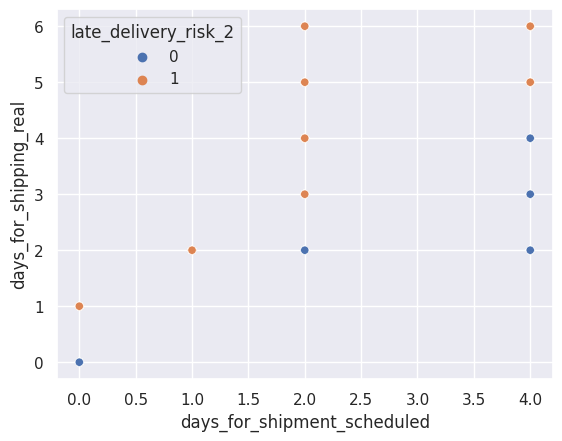

In [ ]:
# 예정된 출고일 기준 배송모드
sns.set()
sns.scatterplot(x="days_for_shipment_scheduled",y="days_for_shipping_real",hue="late_delivery_risk_2",data=data)